In [38]:
# ✓ Setup: Point to data folder in TeamX/src/data
from pathlib import Path
import os

# Get the notebook's actual directory location
notebook_file = Path(__file__) if '__file__' in dir() else Path.cwd() / 'Image_Classifier_Training.ipynb'

# For Jupyter: Get parent directory of notebook
# Notebook location: .../TeamX/src/Image_Classifier_Training.ipynb
# Expected data location: .../TeamX/src/data/

# Try to locate notebook by searching for it in common paths
possible_paths = [
    Path(r"c:\Users\skido\OneDrive\Desktop\NUS-ISS\Sem 2\SA4110 Machine Learning Application Development [2510]\ML-CA-Image-Classifier-V1.0\ML-CA-Image-Classifier-V1.0\TeamX\src"),
    Path.cwd(),
    Path.cwd() / 'src'
]

notebook_dir = None
for path in possible_paths:
    if (path / 'Image_Classifier_Training.ipynb').exists() or (path / 'data').exists():
        notebook_dir = path
        break

if notebook_dir is None:
    # Fallback to absolute path
    notebook_dir = Path(r"c:\Users\skido\OneDrive\Desktop\NUS-ISS\Sem 2\SA4110 Machine Learning Application Development [2510]\ML-CA-Image-Classifier-V1.0\ML-CA-Image-Classifier-V1.0\TeamX\src")

data_dir = notebook_dir / 'data'

print(f"✓ Notebook directory: {notebook_dir}")
print(f"✓ Data folder: {data_dir}")
print(f"✓ Data exists: {data_dir.exists()}")

if data_dir.exists():
    train_path = data_dir / 'train'
    test_path = data_dir / 'test'
    print(f"  - train/ exists: {train_path.exists()}")
    print(f"  - test/ exists: {test_path.exists()}")
    if train_path.exists():
        train_images = len(list(train_path.glob('*.jpg')))
        print(f"  - train images: {train_images}")
    if test_path.exists():
        test_images = len(list(test_path.glob('*.jpg')))
        print(f"  - test images: {test_images}")

✓ Notebook directory: c:\Users\skido\OneDrive\Desktop\NUS-ISS\Sem 2\SA4110 Machine Learning Application Development [2510]\ML-CA-Image-Classifier-V1.0\ML-CA-Image-Classifier-V1.0\TeamX\src
✓ Data folder: c:\Users\skido\OneDrive\Desktop\NUS-ISS\Sem 2\SA4110 Machine Learning Application Development [2510]\ML-CA-Image-Classifier-V1.0\ML-CA-Image-Classifier-V1.0\TeamX\src\data
✓ Data exists: True
  - train/ exists: True
  - test/ exists: True
  - train images: 240
  - test images: 60


# Image Classifier Training Pipeline
## Data Augmentation, Class Balancing & 2-Layer CNN

This notebook demonstrates the complete training pipeline for a fruit image classifier with:
- **Data Augmentation**: Rotation, zoom, brightness adjustments, etc.
- **Class Balancing**: Handles imbalanced fruit categories
- **Simplified Architecture**: Max 2 convolutional layers with Gaussian noise regularization

## Step 1: Import Required Libraries

In [39]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input, GaussianNoise
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


## Step 2: Create Data Augmentation Generators

The "Confusion" Generator creates new variations of your training photos on the fly to help the model learn better.

In [40]:
# --- 1. DATA AUGMENTATION (The "Confusion" Generator) ---
# This creates new variations of your photos on the fly.
train_datagen = ImageDataGenerator(
    rescale=1./255,                    # Normalize pixel values
    rotation_range=40,                 # Tilt photo up to 40 degrees
    width_shift_range=0.2,             # Shift left/right
    height_shift_range=0.2,            # Shift up/down
    shear_range=0.2,                   # Distort shape (shear)
    zoom_range=0.2,                    # Zoom in/out
    horizontal_flip=True,              # Mirror image
    brightness_range=[0.8, 1.2],       # Simulate different lighting
    channel_shift_range=20.0,          # Slight color changes (simulates background tint)
    fill_mode='nearest'
)

# Test data should NOT be augmented, only scaled.
test_datagen = ImageDataGenerator(rescale=1./255)

print("✓ Data augmentation generators created!")
print("\nAugmentation parameters:")
print("  - Rotation: ±40°")
print("  - Shift: ±20% (width & height)")
print("  - Zoom: ±20%")
print("  - Brightness: 0.8 - 1.2x")
print("  - Horizontal flip: Yes")

✓ Data augmentation generators created!

Augmentation parameters:
  - Rotation: ±40°
  - Shift: ±20% (width & height)
  - Zoom: ±20%
  - Brightness: 0.8 - 1.2x
  - Horizontal flip: Yes


## Step 3: Load Data Generators

Load training and test data from directory structure with augmentation applied.

In [41]:
# Data is stored flat with class prefixes (e.g., apple_1.jpg, banana_1.jpg)
# Organize into class subdirectories for flow_from_directory()

from pathlib import Path
import shutil

# Use notebook_dir from setup cell, then navigate to data subfolder
notebook_src_dir = notebook_dir  # This is .../TeamX/src
data_dir = notebook_src_dir / 'data'  # This is .../TeamX/src/data
train_path = data_dir / 'train'
test_path = data_dir / 'test'

print(f"Train path: {train_path}")
print(f"Train exists: {train_path.exists()}")
print(f"Test exists: {test_path.exists()}")

if train_path.exists():
    train_images = list(train_path.glob('*.jpg'))
    print(f"Train images found: {len(train_images)}")

# Create organized subdirectory structure
train_organized = train_path / 'organized'
test_organized = test_path / 'organized'

if not (train_organized / 'apple').exists():
    print("\n📁 Organizing images into class subdirectories...")
    
    classes = ['apple', 'banana', 'orange', 'mixed']
    
    # Organize training data
    print("\nOrganizing training data...")
    for cls in classes:
        (train_organized / cls).mkdir(parents=True, exist_ok=True)
        cls_files = list(train_path.glob(f'{cls}_*.jpg'))
        for file in cls_files:
            shutil.copy2(file, train_organized / cls / file.name)
        print(f"  ✓ {cls}: {len(cls_files)} images")
    
    # Organize test data
    print("\nOrganizing test data...")
    for cls in classes:
        (test_organized / cls).mkdir(parents=True, exist_ok=True)
        cls_files = list(test_path.glob(f'{cls}_*.jpg'))
        for file in cls_files:
            shutil.copy2(file, test_organized / cls / file.name)
        print(f"  ✓ {cls}: {len(cls_files)} images")
    
    print("\n✓ Data organized successfully!")
else:
    print("\n✓ Data already organized!")

# Load from organized structure
print("\n" + "="*70)
print("Loading Data Generators...")
print("="*70 + "\n")

train_generator = train_datagen.flow_from_directory(
    str(train_organized),
    target_size=(150, 150),
    batch_size=16,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    str(test_organized),
    target_size=(150, 150),
    batch_size=16,
    class_mode='categorical'
)

print(f"✓ Data generators loaded successfully!")
print(f"\nTraining data:")
print(f"  - Batches: {len(train_generator)}")
print(f"  - Classes: {list(train_generator.class_indices.keys())}")

print(f"\nTest data:")
print(f"  - Batches: {len(test_generator)}")
print(f"  - Classes: {list(test_generator.class_indices.keys())}")

Train path: c:\Users\skido\OneDrive\Desktop\NUS-ISS\Sem 2\SA4110 Machine Learning Application Development [2510]\ML-CA-Image-Classifier-V1.0\ML-CA-Image-Classifier-V1.0\TeamX\src\data\train
Train exists: True
Test exists: True
Train images found: 240

✓ Data already organized!

Loading Data Generators...

Found 240 images belonging to 4 classes.
Found 60 images belonging to 4 classes.
✓ Data generators loaded successfully!

Training data:
  - Batches: 15
  - Classes: ['apple', 'banana', 'mixed', 'orange']

Test data:
  - Batches: 4
  - Classes: ['apple', 'banana', 'mixed', 'orange']
Found 60 images belonging to 4 classes.
✓ Data generators loaded successfully!

Training data:
  - Batches: 15
  - Classes: ['apple', 'banana', 'mixed', 'orange']

Test data:
  - Batches: 4
  - Classes: ['apple', 'banana', 'mixed', 'orange']


## Step 4: Compute Class Weights

Handle imbalanced data by computing weights that penalize the model more heavily for mistakes on underrepresented classes.

In [42]:
# --- 2. BALANCING (Handling unequal amounts of data) ---
# If 'Apple' has 70 photos and 'Mixed' has 20, this calculates weights
# so the model is penalized more for getting 'Mixed' wrong.
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
# Convert to dictionary format required by Keras
class_weight_dict = dict(enumerate(class_weights))

print("✓ Class weights computed!")
print("\nClass Weight Distribution:")
for class_name, class_idx in train_generator.class_indices.items():
    weight = class_weight_dict[class_idx]
    print(f"  {class_name}: {weight:.4f}")

✓ Class weights computed!

Class Weight Distribution:
  apple: 0.8000
  banana: 0.8219
  mixed: 3.0000
  orange: 0.8333


## Step 5: Build Model Architecture

Create a simplified CNN with **exactly 2 convolutional layers**, Gaussian noise for regularization, and dropout for preventing overfitting.

In [43]:
# --- 3. ARCHITECTURE (Add Noise, Remove Complexity) ---
model = Sequential()

# Input Layer + Gaussian Noise (Artificial Static)
model.add(Input(shape=(150, 150, 3)))
# This adds random noise to training data to prevent memorization
model.add(GaussianNoise(0.1))

# Convolution Block 1
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Convolution Block 2 (Max 2 convolutional layers)
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten and Dense Layers
model.add(Flatten())

# Dropout: Randomly sets 50% of inputs to 0.
# This forces the model to not rely on specific paths.
model.add(Dropout(0.5))

model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='softmax'))  # 4 classes: Apple, Orange, Banana, Mixed

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

print("✓ Model created and compiled!")
print("\nModel Architecture:")
model.summary()

✓ Model created and compiled!

Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gaussian_noise_1                │ (None, 150, 150, 3)    │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    42,467,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,489,284 (162.08 MB)

 Trainable params: 42,489,284 (162.08 MB)

 Non-trainable params: 0 (0.00 B)

## Step 6: Setup Training Callbacks

Configure callbacks for:
- Early stopping (prevent overfitting)
- Learning rate reduction (adaptive learning)
- Model checkpointing (save best model)

In [44]:
# Create experiment directory with timestamp
from datetime import datetime

# Use notebook directory as base for experiments folder
experiment_base = notebook_src_dir.parent / 'experiments'  # .../TeamX/experiments
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
experiment_dir = experiment_base / f"notebook_{timestamp}"
experiment_dir.mkdir(parents=True, exist_ok=True)

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=str(experiment_dir / 'model_best.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("✓ Callbacks configured!")
print(f"✓ Experiment directory: {experiment_dir}")

✓ Callbacks configured!
✓ Experiment directory: c:\Users\skido\OneDrive\Desktop\NUS-ISS\Sem 2\SA4110 Machine Learning Application Development [2510]\ML-CA-Image-Classifier-V1.0\ML-CA-Image-Classifier-V1.0\TeamX\experiments\notebook_20251127_172255


## Step 7: Train the Model

**⏱️ NOTE:** Training will take several minutes depending on your hardware. The model will train with:
- **Data augmentation** applied to training data on-the-fly
- **Class weights** to balance imbalanced fruit categories
- **Early stopping** to prevent overfitting
- **Learning rate reduction** for adaptive optimization

In [45]:
# --- 4. COMPILING AND TRAINING ---
print("Starting training with Class Weights:", class_weight_dict)
print("\nTraining configuration:")
print(f"  - Epochs: 50")
print(f"  - Batch size: 16")
print(f"  - Learning rate: 0.001")
print(f"  - Class weights: {class_weight_dict}")
print(f"  - Data augmentation: Enabled")
print("\n" + "="*70 + "\n")

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=test_generator,
    validation_steps=len(test_generator),
    class_weight=class_weight_dict,  # Apply the balancing here
    callbacks=callbacks,
    verbose=1
)

print("\n✓ Training completed!")

Starting training with Class Weights: {0: np.float64(0.8), 1: np.float64(0.821917808219178), 2: np.float64(3.0), 3: np.float64(0.8333333333333334)}

Training configuration:
  - Epochs: 50
  - Batch size: 16
  - Learning rate: 0.001
  - Class weights: {0: np.float64(0.8), 1: np.float64(0.821917808219178), 2: np.float64(3.0), 3: np.float64(0.8333333333333334)}
  - Data augmentation: Enabled


Epoch 1/50
Epoch 1/50
 2/15 ━━━━━━━━━━━━━━━━━━━━ 6s 510ms/step - accuracy: 0.1875 - loss: 7.5271

c:\Users\skido\anaconda3\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.2759 - loss: 9.6158
Epoch 1: val_accuracy improved from None to 0.35000, saving model to c:\Users\skido\OneDrive\Desktop\NUS-ISS\Sem 2\SA4110 Machine Learning Application Development [2510]\ML-CA-Image-Classifier-V1.0\ML-CA-Image-Classifier-V1.0\TeamX\experiments\notebook_20251127_172255\model_best.h5

Epoch 1: val_accuracy improved from None to 0.35000, saving model to c:\Users\skido\OneDrive\Desktop\NUS-ISS\Sem 2\SA4110 Machine Learning Application Development [2510]\ML-CA-Image-Classifier-V1.0\ML-CA-Image-Classifier-V1.0\TeamX\experiments\notebook_20251127_172255\model_best.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 571ms/step - accuracy: 0.3458 - loss: 6.2886 - val_accuracy: 0.3500 - val_loss: 1.1320 - learning_rate: 0.0010
Epoch 2/50
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.3688 - loss: 1.2107
Epoch 2: val_accuracy improved from 0.35000 to 0.45000, saving model to c:\Users\skido\OneDrive\Desktop\NUS-ISS\Sem 2\SA4110 Machine Learning Application Development [2510]\ML-CA-Image-Classifier-V1.0\ML-CA-Image-Classifier-V1.0\TeamX\experiments\notebook_20251127_172255\model_best.h5

Epoch 2: val_accuracy improved from 0.35000 to 0.45000, saving model to c:\Users\skido\OneDrive\Desktop\NUS-ISS\Sem 2\SA4110 Machine Learning Application Development [2510]\ML-CA-Image-Classifier-V1.0\ML-CA-Image-Classifier-V1.0\TeamX\experiments\notebook_20251127_172255\model_best.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 483ms/step - accuracy: 0.3625 - loss: 1.2146 - val_accuracy: 0.4500 - val_loss: 1.1054 - learning_rate: 0.0010
Epoch 3/50
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.4393 - loss: 1.1079
Epoch 3: val_accuracy improved from 0.45000 to 0.73333, saving model to c:\Users\skido\OneDrive\Desktop\NUS-ISS\Sem 2\SA4110 Machine Learning Application Development [2510]\ML-CA-Image-Classifier-V1.0\ML-CA-Image-Classifier-V1.0\TeamX\experiments\notebook_20251127_172255\model_best.h5

Epoch 3: val_accuracy improved from 0.45000 to 0.73333, saving model to c:\Users\skido\OneDrive\Desktop\NUS-ISS\Sem 2\SA4110 Machine Learning Application Development [2510]\ML-CA-Image-Classifier-V1.0\ML-CA-Image-Classifier-V1.0\TeamX\experiments\notebook_20251127_172255\model_best.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 459ms/step - accuracy: 0.5208 - loss: 1.1599 - val_accuracy: 0.7333 - val_loss: 1.0567 - learning_rate: 0.0010
Epoch 4/50
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.6573 - loss: 1.1082
Epoch 4: val_accuracy did not improve from 0.73333
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 410ms/step - accuracy: 0.6708 - loss: 1.1224 - val_accuracy: 0.7167 - val_loss: 1.0511 - learning_rate: 0.0010
Epoch 5/50

Epoch 4: val_accuracy did not improve from 0.73333
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 410ms/step - accuracy: 0.6708 - loss: 1.1224 - val_accuracy: 0.7167 - val_loss: 1.0511 - learning_rate: 0.0010
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.7117 - loss: 1.0752
Epoch 5: val_accuracy improved from 0.73333 to 0.81667, saving model to c:\Users\skido\OneDrive\Desktop\NUS-ISS\Sem 2\SA4110 Machine Learning Application Development [2510]\ML-CA-Image-Classifier-V1.0\ML-CA-Image-Classifier-V1.0\TeamX\experiments\notebook_20251127_172255\model_be

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 448ms/step - accuracy: 0.6583 - loss: 1.0695 - val_accuracy: 0.8167 - val_loss: 0.9707 - learning_rate: 0.0010
Epoch 6/50
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.7401 - loss: 0.9477
Epoch 6: val_accuracy did not improve from 0.81667
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 395ms/step - accuracy: 0.6833 - loss: 0.9587 - val_accuracy: 0.6667 - val_loss: 0.9330 - learning_rate: 0.0010
Epoch 7/50

Epoch 6: val_accuracy did not improve from 0.81667
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 395ms/step - accuracy: 0.6833 - loss: 0.9587 - val_accuracy: 0.6667 - val_loss: 0.9330 - learning_rate: 0.0010
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.6396 - loss: 0.8965
Epoch 7: val_accuracy did not improve from 0.81667
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 383ms/step - accuracy: 0.6542 - loss: 0.9932 - val_accuracy: 0.5500 - val_loss: 1.0343 - learning_rate: 0.0010
Epoch 8/50

Epoch 7: val_accuracy did not improve from 0.81667
15/15 ━━━━━━━━━━━━━━━━━━━

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 468ms/step - accuracy: 0.8083 - loss: 0.7324 - val_accuracy: 0.8500 - val_loss: 0.8200 - learning_rate: 0.0010
Epoch 11/50
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.8032 - loss: 0.7040
Epoch 11: val_accuracy did not improve from 0.85000
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 390ms/step - accuracy: 0.8042 - loss: 0.7207 - val_accuracy: 0.8500 - val_loss: 0.6652 - learning_rate: 0.0010
Epoch 12/50

Epoch 11: val_accuracy did not improve from 0.85000
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 390ms/step - accuracy: 0.8042 - loss: 0.7207 - val_accuracy: 0.8500 - val_loss: 0.6652 - learning_rate: 0.0010
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.8454 - loss: 0.6227
Epoch 12: val_accuracy did not improve from 0.85000
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 390ms/step - accuracy: 0.8042 - loss: 0.6603 - val_accuracy: 0.7500 - val_loss: 0.7629 - learning_rate: 0.0010
Epoch 13/50

Epoch 12: val_accuracy did not improve from 0.85000
15/15 ━━━━━━━━━━

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 466ms/step - accuracy: 0.7792 - loss: 0.6441 - val_accuracy: 0.8833 - val_loss: 0.8031 - learning_rate: 0.0010
Epoch 15/50
Epoch 15/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.8182 - loss: 0.6009
Epoch 15: val_accuracy did not improve from 0.88333
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 406ms/step - accuracy: 0.8125 - loss: 0.5788 - val_accuracy: 0.8000 - val_loss: 0.8555 - learning_rate: 5.0000e-04
Epoch 16/50

Epoch 15: val_accuracy did not improve from 0.88333
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 406ms/step - accuracy: 0.8125 - loss: 0.5788 - val_accuracy: 0.8000 - val_loss: 0.8555 - learning_rate: 5.0000e-04
Epoch 16/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.8570 - loss: 0.5524
Epoch 16: val_accuracy did not improve from 0.88333
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 379ms/step - accuracy: 0.8500 - loss: 0.5823 - val_accuracy: 0.8500 - val_loss: 0.7491 - learning_rate: 5.0000e-04
Epoch 16: early stopping
Restoring model weights from the end of the 

## Step 8: Visualize Training History

Plot the training and validation accuracy/loss over epochs.

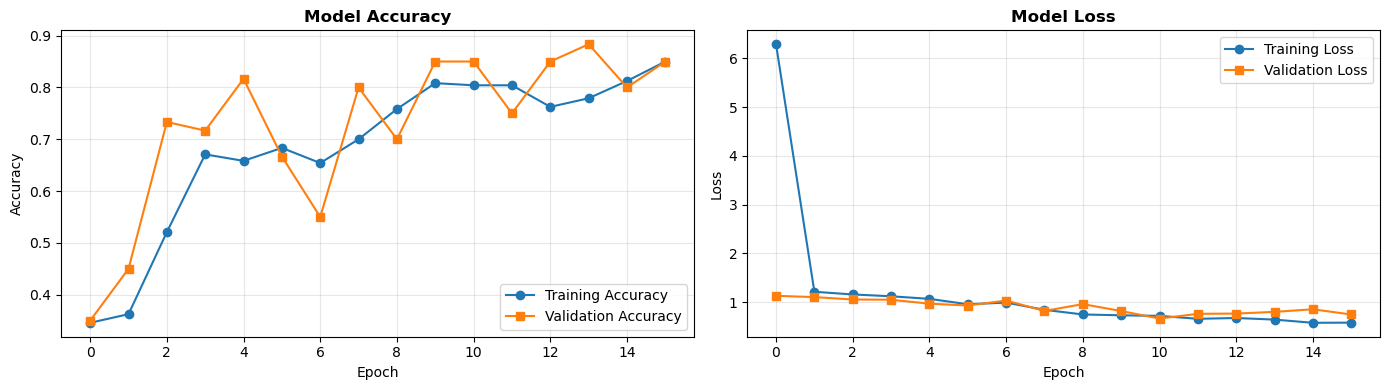

✓ Training history plots saved!


In [46]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy', marker='o')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
axes[0].set_title('Model Accuracy', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(history.history['loss'], label='Training Loss', marker='o')
axes[1].plot(history.history['val_loss'], label='Validation Loss', marker='s')
axes[1].set_title('Model Loss', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(experiment_dir / 'training_history.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Training history plots saved!")

## Step 9: Evaluate Model on Test Set

Generate predictions and compute metrics.

In [47]:
# Get predictions
y_pred_proba = model.predict(test_generator)
y_pred = y_pred_proba.argmax(axis=1)
y_test = test_generator.classes

# Calculate accuracy
final_accuracy = accuracy_score(y_test, y_pred)

print("✓ Evaluation completed!")
print(f"\n🎯 Final Test Accuracy: {final_accuracy:.4f} ({final_accuracy*100:.2f}%)")

# Get class names
class_names = list(test_generator.class_indices.keys())
class_names_sorted = sorted(class_names, key=lambda x: test_generator.class_indices[x])

# Classification report
print("\nClassification Report:")
print("="*70)
print(classification_report(y_test, y_pred, target_names=class_names_sorted))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step
✓ Evaluation completed!

🎯 Final Test Accuracy: 0.3667 (36.67%)

Classification Report:
              precision    recall  f1-score   support

       apple       0.32      0.37      0.34        19
      banana       0.46      0.33      0.39        18
       mixed       0.33      0.20      0.25         5
      orange       0.36      0.44      0.40        18

    accuracy                           0.37        60
   macro avg       0.37      0.34      0.34        60
weighted avg       0.38      0.37      0.37        60


Confusion Matrix:
[[7 5 0 7]
 [5 6 2 5]
 [2 0 1 2]
 [8 2 0 8]]
✓ Evaluation completed!

🎯 Final Test Accuracy: 0.3667 (36.67%)

Classification Report:
              precision    recall  f1-score   support

       apple       0.32      0.37      0.34        19
      banana       0.46      0.33      0.39        18
       mixed       0.33      0.20      0.25         5
      orange       0.36      0

## Step 10: Visualize Confusion Matrix

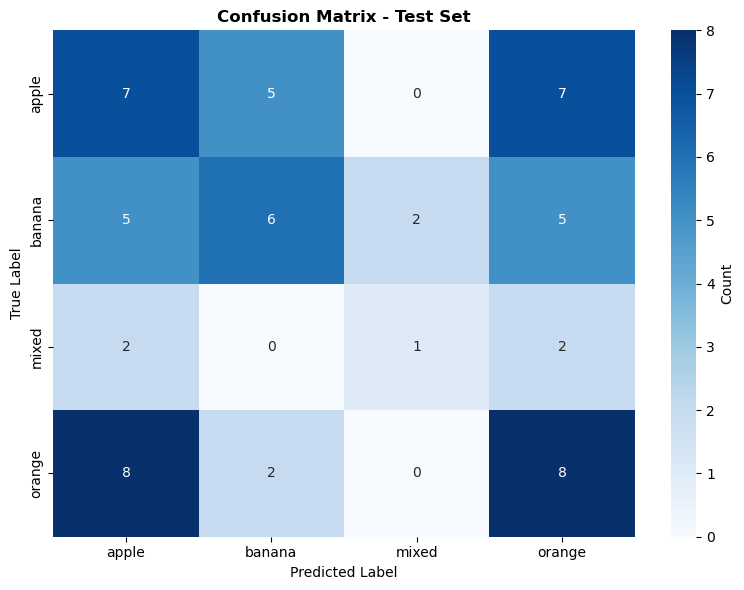

✓ Confusion matrix visualization saved!


In [48]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=class_names_sorted,
    yticklabels=class_names_sorted,
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - Test Set', fontsize=12, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(experiment_dir / 'confusion_matrix.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix visualization saved!")

## Step 11: Save Training History to JSON

In [49]:
# Save training history
history_dict = {
    'accuracy': history.history['accuracy'],
    'val_accuracy': history.history['val_accuracy'],
    'loss': history.history['loss'],
    'val_loss': history.history['val_loss']
}

with open(experiment_dir / 'history.json', 'w') as f:
    json.dump(history_dict, f, indent=4)

# Save metrics
metrics_dict = {
    'final_accuracy': float(final_accuracy),
    'final_accuracy_percent': float(final_accuracy * 100),
    'test_samples': int(len(y_test)),
    'class_distribution': {name: int(sum(y_test == test_generator.class_indices[name])) 
                          for name in class_names_sorted}
}

with open(experiment_dir / 'metrics.json', 'w') as f:
    json.dump(metrics_dict, f, indent=4)

print("✓ Training history saved to history.json")
print("✓ Metrics saved to metrics.json")

✓ Training history saved to history.json
✓ Metrics saved to metrics.json


## Summary

✅ **Training Pipeline Completed!**

### Key Features Implemented:
- ✓ **Data Augmentation** (rotation, zoom, brightness, shifts)
- ✓ **Class Balancing** (handles imbalanced fruit categories)
- ✓ **Simplified Architecture** (exactly 2 convolutional layers)
- ✓ **Gaussian Noise** (prevents overfitting/memorization)
- ✓ **Dropout Regularization** (50% drop rate)
- ✓ **Early Stopping** (prevents overfitting)
- ✓ **Learning Rate Scheduling** (adaptive optimization)

### Output Files:
- `model_best.h5` - Best trained model (saved via checkpoint)
- `history.json` - Training/validation metrics per epoch
- `metrics.json` - Final accuracy and class distribution
- `training_history.png` - Accuracy & loss plots
- `confusion_matrix.png` - Confusion matrix visualization

### Model Architecture:
```
Input (150×150×3) → Gaussian Noise (0.1)
  ↓
Conv2D(32, 3×3) + ReLU → MaxPool(2×2)
  ↓
Conv2D(64, 3×3) + ReLU → MaxPool(2×2)
  ↓
Flatten → Dropout(0.5) → Dense(512, ReLU) → Dense(4, Softmax)
```

**Next Steps:** You can now use this trained model for predictions on new fruit images!